CLUSTERING CON INCERTIDUMBRE

Primero, para poder ejecutar el código es necesario instalar los paquetes msotrados. Si no te deja, es necesario indicar en el comando de "pip install" el flag --User o -U

In [1]:
#Packages to install

#!pip install pandas
#!pip install numpy
#!pip install scipy
#!pip install matplotlib
#!pip install scikit-learn
#!pip install ipywidgets

A continuación los imports necesarios. De momento ipywidgtes no es necesario por lo que se puede comentar si da algún tipo de problema

In [2]:
#Imports

import math
import pandas as pd
import numpy as np
import scipy as sp
import random as rd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from sklearn import preprocessing

#Interactive plot
#%matplotlib notebook
%matplotlib inline

La primera clase creada es DataSet.

Esta estructura de datos tiene como objetivo facilitar el cargar archivos haciendo uso de la librería pandas. 

En el constructor solo tienes que pasar la ruta de archivo deseada. De momento el código mostrado tiene rutas ed archivo locales y no relativas. Comprobar que las rutas están bien en caso de error.

Para leer el archivo deseado, llamar al método Read el cual incluye como parámetro el carácter de separación, el cual siempre debe ser ','.

La ventaja de esta estructura de datos es que podemos dibujar directamente los puntos del archivo csv.

In [3]:
class DataSet:
    
    data = []
    list_points = []
    drawPoint = []
    
    def __init__(self, file_path):
        
        data = []
        list_points = []
        drawPoint = []
        
        self.file_path = file_path
        
    #Derived
    def Read(self, sep):
        self.data = pd.read_csv(self.file_path, sep=sep,encoding='utf8')
        
        points = []
        allX = []
        allY =[]
        
        for index, row in self.data.iterrows():
            p = Point(row['Coord X'],row['Coord Y'])
            points.append(p)
            allX.append(p.x)
            allY.append(p.y)
            
        self.list_points = points
        self.drawPoint.append(allX)
        self.drawPoint.append(allY) 
        
    def DrawData(self, drawType):       
        plt.plot(self.drawPoint[0],self.drawPoint[1],drawType)

La clase punto siemplemente se encarga de guardar dos valores, las componentes de una coordenada: posición x e y.

In [4]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def getFurthestPoint(self,points):
        
        res = Point(0,0)
        auxDis = 0.0
        
        for i in range(0,len(points)):
            dis = self.CalculateDistanceToPoint(points[i])
            
            if(dis>auxDis):
                auxDis = dis
                res = points[i]
            
        return res
    
    def CalculateDistanceToCluster(self,c):
        dis = self.CalculateDistanceToPoint(c.center)
        return abs(dis - c.radius)
    
    def calcThresh(self,circles):
        
        distances = []
        distances_n = []
        
        for i in range(0,len(circles)):
            distances.append(self.CalculateDistanceToCluster(circles[i]))
                
        mod = 0.0
        for i in range(0,len(distances)):
            mod += distances[i]
        
        distances_n = np.array(distances)*(1/mod)

        return distances_n
    
    def CalculatePerpendicular(self,p):
        #Punto medio
        xMean = (self.x + p.x)/2
        yMean = (self.y + p.y)/2
        
        #Pendiente usando: y - y1 = m(x - x1) y  mp = -1/m
        m = -1/((p.y - self.y)/(p.x - self.x))
        
        #Se devuelve [x,y,b]
        perpendicular = ([-m,1,m*(-xMean)+yMean])
        
        return perpendicular
    
    def CalculateDistanceToPoint(self,p):
        disX = p.x - self.x
        disY = p.y - self.y
        dis = math.sqrt(disX*disX + disY*disY)
        
        return dis

La clase círculo como su nombre bien indica es una estructura de datos encargada de gestionarlo.

Contiene la información del centro de la circunferencia, radio, numero de putnos que se compone y sus valores en coordenadas.

En el constructor simplemente se pasa el centro, radio y número de puntos deseados. 

El método Update simplemente modifica los valores de centro y radio.

El método Draw se limita a realizar un esbozo del círculo.

In [5]:
class Circle:
    
    center = 0
    readius = 0
    numOfPoints = 0
    xVals = []
    yVals = []
    
    def __init__(self, center, radius, numOfPoints):
        self.center = center
        self.radius = radius
        self.numOfPoints = numOfPoints
        self.__Calculate()
      
    #Derived
    def __Calculate(self):
        
        self.xVals = []
        self.yVals = []
        
        alpha = 2*math.pi/self.numOfPoints
        i = 0     
        while i < 2*math.pi:
            self.xVals.append(self.center.x + self.radius*math.cos(i))
            self.yVals.append(self.center.y + self.radius*math.sin(i))
            i += alpha
            
    def Update(self, center, radius):
        self.center = center
        self.radius = radius
        self.__Calculate()
    
    def Draw(self):
        if(len(self.xVals) == 0 or len(self.yVals) == 0):
            print('Error when drawing: Values are empty')
        else:
            xPrimeVals = self.xVals
            xPrimeVals.append(xPrimeVals[0])
            
            yPrimeVals = self.yVals
            yPrimeVals.append(yPrimeVals[0])
            
            plt.plot(xPrimeVals,yPrimeVals)
            plt.plot(self.center.x,self.center.y,'bo')
            
    def CalculateFrom3Points(p1,p2,p3):
        #Mediatrices
        perp1 = p1.CalculatePerpendicular(p2)
        perp2 = p1.CalculatePerpendicular(p3)
        
        #Circuncentro
        A = [[perp1[0],perp1[1]],[perp2[0],perp2[1]]]
        
        if(np.linalg.det(A)==0):
            return Point(0,0),-1
        else:
            B = [[perp1[2]],[perp2[2]]]
            X = np.linalg.solve(A,B)
            circumcenter = Point(X[0],X[1])

            #Radio
            radius = circumcenter.CalculateDistanceToPoint(p1)

            return circumcenter, radius
        
    def CalculateBaricentro(listPoints):
        
        sumX = 0
        sumY = 0
        radius = 0
        
        for i in range(0,len(listPoints)):
            sumX = sumX + listPoints[i].x
            sumY = sumY + listPoints[i].y
        
        center = Point(sumX/len(listPoints),sumY/len(listPoints))
        
        for i in range(0,len(listPoints)):
            radius = radius + center.CalculateDistanceToPoint(listPoints[i])
        
        radius = radius/len(listPoints)
        
        return center,radius

La Clase canvas es la que usaremos principalmente para visualziar los datos.

Recibe como parámetro una altura, anchura y datos.

Lo más importante de esta clase es el transformar los Datos a Puntos del que se encarga el método privado "__DataToPoints".

Luego tenemos más métodos:

DrawData(): Simplemente dibuja los puntos que se han pasado en el constructor

RemoveRandomPoints(percentage): Para eliminar puntos de los datos. Indica el porcentaje de los puntos que quieran ser borrados, de forma aleatoria.

InsertNoise(devX,devY): Para añadir ruido a los datos. Se pasa como parámetro la desviación que queremos tanto en la X como en la Y

Luego tenemos dos métodos para generar circunferencias alteatorias con el objetivo de generar Datos.

DrawRandomCircles_r(numOfCircles, precision): Genera circufnerencias aletatoris con un radio alteatorio. Genera tantas circufnerencias como se indique en el parámetro de la función

DrawRandomCircles(numOfCircles, minRadius, maxRadius, precision): Igual que "DrawRandomCircles_r" pero además indicando las longitudes del radio que deseemos.

In [6]:
class Canvas:
    
    width = 0
    height = 0
    data = []
    points = []
    
    def __init__(self, width, height, data):
        self.width = width
        self.height = height
        self.data = data
        self.points = self.__DataToPoints()
   
    #Derived
    def __DataToPoints(self):
        res = []        
        for i in range (0,len(self.data)):            
            for j in range(0,self.data[i].numOfPoints):                
                point=[]
                point.append(self.data[i].xVals[j])
                point.append(self.data[i].yVals[j])              
                point.append("Circulo"+str(i+1))
                
                res.append(point)
        return res
    
    def DrawData(self):
        for i in range (0,len(self.points)):
            plt.plot(self.points[i][0],self.points[i][1],'ro')
    
    def RemoveRandomPoints(self,percentage):
        
        if len(self.points) != 0:
            pointsToRemove = int(len(self.points)*percentage)
            newArrayLen = len(self.points)

            for i in range (0, pointsToRemove):
                j = rd.randint(0,newArrayLen-1)
                self.points.pop(j)
                newArrayLen -= 1
        else:
            print("Data debe tener al menos un punto.")
    
    def InsertNoise(self,devX,devY):
        noiseX = np.random.normal(0,devX,len(self.points))
        noiseY = np.random.normal(0,devY,len(self.points))
        
        for i in range(0,len(self.points)):
            self.points[i][0] += noiseX[i]
            self.points[i][1] += noiseY[i]
            
    def DrawRandomCircles_r(self,numOfCircles, precision):
            
        for i in range (0,numOfCircles):
            
            maxRad = 0
            
            if(self.width > self.height):
                maxRad = self.height/2
            else:
                 maxRad = self.width/2
            
            radius = rd.uniform(1,maxRad)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)
                       
            c = Circle(Point(centerX,centerY),radius,precision)
            self.data.append(c)
            c.Draw()
        
        self.points = self.__DataToPoints()
            
    def DrawRandomCircles(self,numOfCircles, minRadius, maxRadius, precision):
            
        for i in range (0,numOfCircles):
                       
            radius = rd.uniform(minRadius,maxRadius)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)                       
            c = Circle(Point(centerX,centerY),radius,precision)
            
            self.data.append(c)
            c.Draw()
            
        self.points = self.__DataToPoints()

In [97]:
class ClusteringSolver:
    
    circles = []
    numCirculo = 0

    def __init__(self,file_path,numCirculo):
        
        self.dataSet = DataSet(file_path)
        self.dataSet.Read(',')        
        self.circles = []
        
        self.numCirculo = numCirculo
        
        #for i in range (0,numCirculo):
         #self.initRandomCluster()
        
        self.Ganamos(self.dataSet.list_points)
    
    def initRandomCluster(self):
        
        radius = rd.uniform(2,10)
        centerX = rd.uniform(10,90)
        centerY = rd.uniform(10,90)
                       
        c = Circle(Point(centerX,centerY),radius,20)
            
        self.circles.append(c)
        
    def initCluster(self):
        index = round(len(self.dataSet.list_points)/self.numCirculo)
        
        i = 0

        while i < index*self.numCirculo:

            radius = rd.uniform(2,10)
            
            if(i == 0):
                centerX = self.dataSet.list_points[i].x - radius
                centerY = self.dataSet.list_points[i].y - radius
                               
            else:
            
                centerX = self.dataSet.list_points[i].x - radius
                centerY = self.dataSet.list_points[i].y - radius
                
                c1 = Point(centerX,centerY)
                
                for j in range (0,len(self.circles)):
                    
                    c2 = Point(self.circles[j].center.x,self.circles[j].center.y)
                    dis = c1.CalculateDistanceToPoint(c2)
                    sol = dis - radius - self.circles[j].radius
                    
                    if(sol < 0):
                        radius = abs(radius + sol)
            
            i = i + index
            c = Circle(Point(centerX,centerY),radius,20)
            self.circles.append(c)
            
    def Ganamos(self, listOfPoints):
        
        temp_c = []
        tempRadio = 5
        
        i=0
        j=0
        while i < 100:
            while j < 100:
                c = Circle(Point(i,j),tempRadio,20)
                j = j + tempRadio*2
                temp_c.append(c)
            i = i + tempRadio*2
            j = 0
        
        for i in range(0,len(temp_c)):
            for j in range(0,len(listOfPoints)):
                if(temp_c[i].center.CalculateDistanceToPoint(listOfPoints[j]) < tempRadio):
                    self.circles.append(temp_c[i])
                    break                    
                    
    def CalculateThreshold(self):
        
        threshold = []
        
        for i in range(0,len(self.dataSet.list_points)):
            p = self.dataSet.list_points[i]
            threshold.append(p.calcThresh(self.circles))
            
        assignedCluster = []  
        
        for i in range(0,len(threshold)):
            tuplePointCircle = []
            index = 0
            auxVal = 0
            point = Point(0,0)
            
            for j in range(0,len(threshold[i])):
                if(j==0):
                    auxVal = threshold[i][j]
                    point = self.dataSet.list_points[i]
                    index = j
                else:
                    if(threshold[i][j] < auxVal):
                        auxVal = threshold[i][j]
                        point = self.dataSet.list_points[i]
                        index = j
                        
            tuplePointCircle.append(point)
            tuplePointCircle.append(index)
            assignedCluster.append(tuplePointCircle)
            
            tuplePointCircle = []
            index = 0
            point = Point(0,0)
            auxVal = 0
    
        return assignedCluster
    
    def CalculateBestFitPoints(self,listOfPoints):     
        index = round(len(listOfPoints)/3)
        return listOfPoints[0],listOfPoints[index],listOfPoints[index*2]
    
    def CalculateCircunference(self,listOfPoints):
        """"
        radius = -1
        while radius == -1:
            p1,p2,p3 = self.CalculateBestFitPoints(listOfPoints)
            center, radius = Circle.CalculateFrom3Points(p1,p2,p3)  
        """
        
        center, radius = Circle.CalculateBaricentro(listOfPoints)  
        
        return center, radius
    
    def Learn(self,iterations):
                
        for i in range(0,iterations):
            data = self.CalculateThreshold()
            
            data2Group = []
            
            for j in range(0,len(self.circles)):
                
                group = []
                           
                for k in range(0,len(data)):
                    if(j == data[k][1]):
                        p = Point(data[k][0].x,data[k][0].y)
                        group.append(p)
                           
                data2Group.append(group)
                
            for j in range(0,len(data2Group)):
                c,r = self.CalculateCircunference(data2Group[j])
                self.circles[j].Update(c,r)

        return data

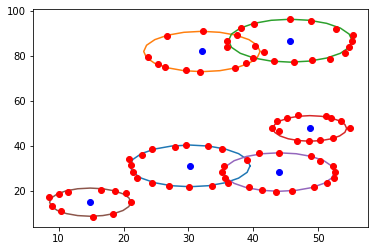

In [127]:
canvas2 = Canvas(100,100,[])
canvas2.DrawRandomCircles(6,5,10,20)
canvas2.RemoveRandomPoints(0.3)
canvas2.InsertNoise(0.4,0.2)
canvas2.DrawData()
headers = ['Coord X','Coord Y', 'Circulo']
df = pd.DataFrame(canvas2.points, columns= headers)

In [128]:
file_path = r"C:\Users\enri8\Desktop\Universidad\IA\Proyecto\Clustering\Datos\datos_xport.csv"
df = df.sample(frac=1)
df.to_csv(file_path, columns=headers, index=False, encoding="utf8")

In [129]:
setDatos = DataSet(file_path)
setDatos.Read(',')

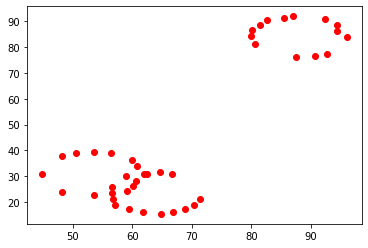

In [130]:
setDatos.DrawData('ro')

Definición del algoritmo segun el pseudocódigo

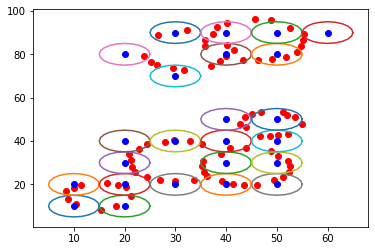

In [131]:
cs = ClusteringSolver(file_path,3)
canvas2.DrawData()
for i in range(0,len(cs.circles)):
    cs.circles[i].Draw()

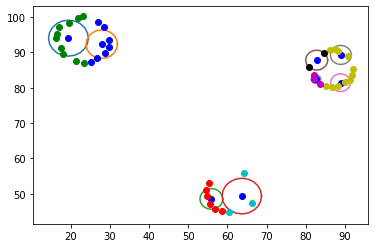

In [90]:
#print(cs.dataSet.data)
thresh = cs.Learn(1000)

for i in range (0,len(cs.circles)):
    cs.circles[i].Draw()

for i in range(0,len(thresh)):    
    if(thresh[i][1] == 0):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'go')
    elif(thresh[i][1] == 1):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'bo')
    elif(thresh[i][1] == 2):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'ro')
    elif(thresh[i][1] == 3):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'co')
    elif(thresh[i][1] == 4):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'mo')
    elif(thresh[i][1] == 5):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'ko')
    else:
        plt.plot(thresh[i][0].x,thresh[i][0].y,'yo')

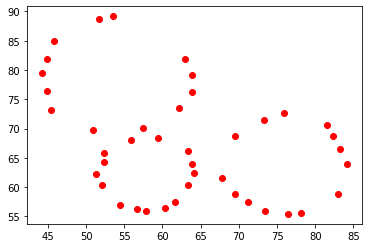

In [66]:
cs.dataSet.DrawData('ro')

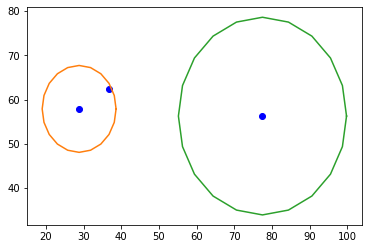

In [47]:
for i in range (0,len(cs.circles)):
    cs.circles[i].Draw()

In [48]:
print(len(cs.circles))

3


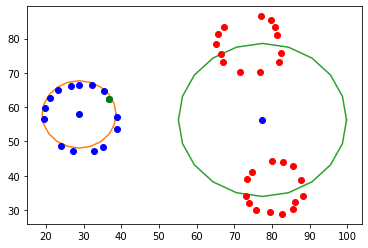

In [49]:
thresh = cs.CalculateThreshold()

for i in range (0,len(cs.circles)):
    cs.circles[i].Draw()

for i in range(0,len(thresh)):    
    if(thresh[i][1] == 0):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'go')
    elif(thresh[i][1] == 1):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'bo')
    elif(thresh[i][1] == 2):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'ro')
    elif(thresh[i][1] == 3):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'co')
    elif(thresh[i][1] == 4):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'mo')
    elif(thresh[i][1] == 5):
        plt.plot(thresh[i][0].x,thresh[i][0].y,'ko')
    else:
        plt.plot(thresh[i][0].x,thresh[i][0].y,'yo')

0
12
24


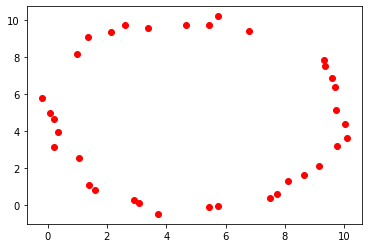

In [24]:
circ = Circle(Point(5,5),5,50)

can = Canvas(100,100,[circ])
can.RemoveRandomPoints(0.3)
can.InsertNoise(0.2,0.2)
can.DrawData()

headers = ['Coord X','Coord Y', 'Circulo']

datfr = pd.DataFrame(can.points, columns= headers)
file_path_c = r"C:\Users\enri8\Desktop\Universidad\IA\Proyecto\Clustering\Datos\datos_circulo.csv"
datfr.to_csv(file_path_c, columns=headers, index=False, encoding="utf8")

cs2 = ClusteringSolver(file_path_c,3)
points = cs2.dataSet.list_points



0
      Coord X   Coord Y   Circulo
0   10.132722  4.887046  Circulo1
1    8.184996  9.077012  Circulo1
2    4.992634  9.864654  Circulo1
3    3.359555  9.852829  Circulo1
4    1.838146  9.059917  Circulo1
5    0.504732  7.012069  Circulo1
6    0.252500  5.159613  Circulo1
7    0.923217  2.016972  Circulo1
8    2.143954  0.908452  Circulo1
9    2.948288  0.540794  Circulo1
10   5.141014  0.661551  Circulo1
11   9.748638  3.481232  Circulo1


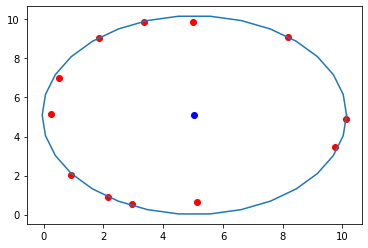

In [20]:
#Calcular circunferencia a partir de un conjunto de puntos

#Creación de puntos a partir de circunferencia
circ = Circle(Point(5,5),5,20)
can = Canvas(100,100,[circ])
can.RemoveRandomPoints(0.4)
can.InsertNoise(0.2,0.2)
can.DrawData()

#Creación de csv con los puntos 
headers = ['Coord X','Coord Y', 'Circulo']
datfr = pd.DataFrame(can.points, columns= headers)
file_path_c = r"C:\Users\enri8\Desktop\Universidad\IA\Proyecto\Clustering\Datos\datos_circulo.csv"
datfr.to_csv(file_path_c, columns=headers, index=False, encoding="utf8")

#Puntos del problema 
cs2 = ClusteringSolver(r"C:\Users\enri8\Desktop\Universidad\IA\Proyecto\Clustering\Datos\datos_circulo.csv",1)
points = cs2.dataSet.list_points

#Cálculo circunferencia
c,r = cs2.CalculateCircunference(points)
circ = Circle(c,r,30)

print(cs2.dataSet.data)

circ.Draw()

In [21]:
def CalculateBestFitPoints(self,listOfPoints):     
        
        sumX = 0.0
        sumY = 0.0
        distance = 0.0
        auxPoint = []
        auxCenter = 0 
        
        for i in range(0,len(listOfPoints)):
            
            #furthests point from points        
            for j in range(0,len(listOfPoints)):
                actDistance = math.sqrt(pow(listOfPoints[j].x-listOfPoints[i].x,2)+pow(listOfPoints[j].y-listOfPoints[i].y,2))
                if(actDistance > distance):
                    distance = actDistance
                    auxPoint = [listOfPoints[i],listOfPoints[j]]
            
            sumX += listOfPoints[i].x
            sumY += listOfPoints[i].y
        
        p = Point(sumX/len(listOfPoints),sumY/len(listOfPoints))
        
        vecL = Point((auxPoint[0].x+auxPoint[1].x)/2,(auxPoint[0].y+auxPoint[1].y)/2)
    
        newVec = Point(p.x-vecL.x,p.y - vecL.y)
        rect = Point(newVec.y, -newVec.x)
        c = -(rect.x * p.x + rect.y * p.y)
        
        auxVal = 10
        closestPoint = 0
        for j in range(0,len(listOfPoints)):
            
            val = abs(rect.x * listOfPoints[j].x + rect.y * listOfPoints[j].y + c)
            if(j == 0):
                auxVal = val
            else:
                if(val < auxVal):
                    auxVal = val
                    closestPoint = listOfPoints[j]
        
       
        plt.plot(auxPoint[0].x,auxPoint[0].y,'go')
        plt.plot(closestPoint.x,closestPoint.y,'go')
        plt.plot(auxPoint[1].x,auxPoint[1].y,'go')
        
        return p,auxPoint

def preuba_1():
        sumX = 0.0
        sumY = 0.0
        distance = 0.0
        auxPoint = []
        auxCenter = 0 
        
        for i in range(0,len(listOfPoints)):
            
            #furthests point from points        
            for j in range(0,len(listOfPoints)):
                actDistance = math.sqrt(pow(listOfPoints[j].x-listOfPoints[i].x,2)+pow(listOfPoints[j].y-listOfPoints[i].y,2))
                if(actDistance > distance):
                    distance = actDistance
                    auxPoint = [listOfPoints[i],listOfPoints[j]]
            
            sumX += listOfPoints[i].x
            sumY += listOfPoints[i].y
        
        p = Point(sumX/len(listOfPoints),sumY/len(listOfPoints))
        
        dist = math.sqrt(pow(p.x-listOfPoints[0].x,2)+pow(p.y-listOfPoints[0].y,2))
        
        pps=[]
        count = 2
        k = 0
        for i in range(0,len(listOfPoints)-1):
            if(count == 0):
                break
                
            actDistance = math.sqrt(pow(listOfPoints[i].x-listOfPoints[k].x,2)+pow(listOfPoints[i].y-listOfPoints[k].y,2))
            
            if(actDistance >= dist):
                pps.append(listOfPoints[i])
                count-=1
                k = i
                
        return listOfPoints[0],pps[0],pps[1]
    
def elMierdasEste(self,listOfPoints):     
        index = round(len(listOfPoints)/3)
        return listOfPoints[0],listOfPoints[index],listOfPoints[index*2]